# Analysis-PCA

This ipynb file is for text analysis, particularly for PCA.

In [44]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import nltk
import plotly_express as px
from numpy.linalg import norm
from scipy.linalg import eigh
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from scipy.linalg import eigh
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px
from gensim.models import word2vec
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_in = "./data"

In [3]:
CORPUS = pd.read_csv(data_in+"/CORPUS.csv").drop("Unnamed: 0", axis=1)
LIB = pd.read_csv(data_in+"/LIB.csv")
VOCAB = pd.read_csv(data_in+"/VOCAB.csv")

In [4]:
CORPUS.sample(4)

,text_num,para_num,sent_num,token_num,pos_tuple,pos,token_str,term_str,source
241910,245,16,0,8,"('your', 'PRP$')",PRP$,your,your,CNN
568712,647,0,0,15,"('dangers', 'NNS')",NNS,dangers,dangers,CNBC
650017,762,10,0,13,"('on', 'IN')",IN,on,on,CNBC
315976,323,21,0,23,"('ads', 'NNS')",NNS,ads,ads,CNN


In [5]:
LIB.sample(4)

,source_id,date,url,title,text
926,CNBC,2020/12/22,https://www.cnbc.com/2020/12/22/trump-calls-co...,trump call covid relief bill unsuitable deman...,"President Donald Trump, in a stunning nighttim..."
630,CNBC,2020/12/18,https://www.cnbc.com/2020/12/18/bidens-ustr-pi...,bidens ustr pick katherine tai tough china ex...,U.S. President-elect Joe Bidens pick for his i...
915,CNBC,2020/10/15,https://www.cnbc.com/2020/10/15/house-lawmaker...,house lawmaker propose social security,The Social Security Administration announced t...
439,CNN,NaN,https://www.cnn.com/travel/article/hawaii-bost...,travel article hawaii boston long flight unite...,Here’s a little holiday cheer: Hawaii is openi...


In [6]:
VOCAB.sample(4)

,term_str,n,n_chars,p,i,max_pos,n_pos,stop,stem_porter,stem_snowball,stem_lancaster
20120,shuffled,1,8,0.000001,19.621403,VBD,1,0,shuffl,shuffl,shuffl
20202,silver,24,6,0.000030,15.036440,NN,2,0,silver,silver,silv
1874,apocalyptic,5,11,0.000006,17.299475,JJ,1,0,apocalypt,apocalypt,apocalypt
16231,pathogen,7,8,0.000009,16.814048,NN,1,0,pathogen,pathogen,pathog


In [7]:
tf_method = 'sum'         # sum, max, log, double_norm, raw, binary
tf_norm_k = .5            # only used for double_norm
idf_method = 'standard'   # standard, max, smooth
gradient_cmap = 'YlGnBu'  # YlGn, GnBu, YlGnBu; For tables; see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html 


OHCO = ['source', 'text_num', 'para_num', 'sent_num', 'token_num']
SENTS = OHCO[:4]
PARAS = OHCO[:3]
ARTICLES = OHCO[:2]
SOURCES = OHCO[:1]

In [8]:
CORPUS = CORPUS.reset_index().set_index(OHCO).drop("index", axis=1)

In [9]:
CORPUS

pos_tuple  pos  \
source text_num para_num sent_num token_num                                
CNN    0        0        0        0                   ('two', 'CD')   CD   
                                  1                 ('more', 'JJR')  JJR   
                                  2              ('infants', 'NNS')  NNS   
                                  3                 ('have', 'VBP')  VBP   
                                  4           ('contracted', 'VBN')  VBN   
...                                                             ...  ...   
CNBC   989      17       2        19              ('healing', 'NN')   NN   
                                  20               ('planet', 'NN')   NN   
                                  21                   ('to', 'TO')   TO   
                                  22               ('future', 'JJ')   JJ   
                                  23         ('generations', 'NNS')  NNS   

                                               token_str     term_str  
source text_num para_num sent_num token_num                            
CNN    0        0        0        0                  two          two  
                                  1                 more         more  
                                  2              infants      infants  
                                  3                 have         have  
                                  4           contracted   contracted  
...                                                  ...          ...  
CNBC   989      17       2        19             healing      healing  
                                  20              planet       planet  
                                  21                  to           to  
                                  22              future       future  
                                  23         generations  generations  

[806549 rows x 4 columns]

In [10]:
def BOW(df, bag):
    bow = df.groupby(bag+['term_str']).term_str.count().to_frame('n') 
    return bow

In [11]:
def calculate_tfidf(bow_table,tf_method):
    
    DTCM = bow_table.n.unstack().fillna(0).astype('int')
    
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log':
        TF = np.log2(1 + DTCM.T)
    elif tf_method == 'raw':
        TF = DTCM.T
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    
    TF = TF.T
    
    # compute DF
    DF = DTCM.astype('bool').sum()
    
    # compute IDF
    N = DTCM.shape[0]
    
    if idf_method == 'standard':
        IDF = np.log2(N / DF)
    elif idf_method == 'max':
        IDF = np.log2(DF.max() / DF) 
    elif idf_method == 'smooth':
        IDF = np.log2((1 + N) / (1 + DF)) + 1
    
    # compute TFIDF
    TFIDF = TF * IDF
    
    return(TFIDF,TF,DF,IDF)

In [12]:
BOW_SOURCES = BOW(CORPUS, SOURCES)
BOW_ARTICLES = BOW(CORPUS, ARTICLES)

In [13]:
tfidf_articles, tf_articles, df_articles, idf_articles = calculate_tfidf(BOW_ARTICLES,'max')
tfidf_sources, tf_sources, df_sources, idf_sources = calculate_tfidf(BOW_SOURCES,'max')

In [14]:
tfidf_articles.mean().sort_values(ascending=False)\
    .head(20).to_frame('mean_tfidf').reset_index().join(VOCAB.max_pos).set_index("term_str")

,mean_tfidf,max_pos
term_str,,
trump,0.093882,CD
you,0.070173,CD
your,0.069067,CD
biden,0.064063,CD
her,0.060828,CD
his,0.057643,CD
she,0.055750,CD
i,0.055270,CD
he,0.054128,CD


In [15]:
tfidf_sources.mean().sort_values(ascending=False)\
    .head(20).to_frame('mean_tfidf').reset_index().join(VOCAB.max_pos).set_index("term_str")

,mean_tfidf,max_pos
term_str,,
thats,0.005644,CD
cnbcs,0.005360,CD
youre,0.004201,CD
dow,0.003891,CD
cramer,0.003866,CD
premarket,0.003685,CD
theres,0.003324,CD
companys,0.002989,CD
nasdaq,0.002938,CD


In [16]:
VOCAB = VOCAB.set_index("term_str")

#### By articles

In [24]:
BOW_ARTICLES['tf'] = tf_articles.stack()
BOW_ARTICLES['tfidf'] = tfidf_articles.stack()

In [19]:
VOCAB_articles = VOCAB.copy()
VOCAB_articles['df'] = df_articles
VOCAB_articles['idf'] = idf_articles
VOCAB_sources = VOCAB.copy()
VOCAB_sources['df'] = df_sources
VOCAB_sources['idf'] = idf_sources

In [28]:
VOCAB_articles['tfidf_mean'] = BOW_ARTICLES.groupby('term_str').tfidf.mean()
VOCAB_articles['tfidf_sum'] = tfidf_articles.sum()
VOCAB_articles['tfidf_median'] = BOW_ARTICLES.groupby('term_str').tfidf.median()
VOCAB_articles['tfidf_max'] = tfidf_articles.max()
VOCAB_articles['dfidf'] = VOCAB_articles.df * VOCAB_articles.idf

In [30]:
VOCAB_articles.sort_values('tfidf_mean', ascending = False)[['max_pos', 'i','tfidf_mean', 'tfidf_median', 'tfidf_max', 'dfidf']].head(20).style.background_gradient(cmap=gradient_cmap)

,max_pos,i,tfidf_mean,tfidf_median,tfidf_max,dfidf
term_str,,,,,,
debatelocation,NN,15.036440,7.704220,7.704220,7.704220,9.951285
grissom,NN,16.621403,7.161028,7.161028,7.161028,17.902569
bruno,NN,14.920963,6.464817,6.464817,6.464817,17.902569
chopra,NN,16.299475,6.219553,6.219553,6.219553,9.951285
2016event,CD,15.373475,6.099175,6.099175,6.099175,9.951285
boats,NNS,16.621403,5.967523,5.967523,5.967523,17.902569
toobin,NN,16.621403,5.686448,5.686448,5.686448,9.951285
boylan,NN,16.621403,5.686448,5.686448,5.686448,9.951285
carey,NN,17.299475,5.528492,5.528492,5.528492,9.951285


#### By articles

In [31]:
BOW_SOURCES['tf'] = tf_sources.stack()
BOW_SOURCES['tfidf'] = tfidf_sources.stack()

In [32]:
VOCAB_sources['tfidf_mean'] = BOW_SOURCES.groupby('term_str').tfidf.mean()
VOCAB_sources['tfidf_sum'] = tfidf_sources.sum()
VOCAB_sources['tfidf_median'] = BOW_SOURCES.groupby('term_str').tfidf.median()
VOCAB_sources['tfidf_max'] = tfidf_articles.max()
VOCAB_sources['dfidf'] = VOCAB_sources.df * VOCAB_sources.idf

In [33]:
VOCAB_sources.sort_values('tfidf_mean', ascending = False)[['max_pos', 'i','tfidf_mean', 'tfidf_median', 'tfidf_max', 'dfidf']].head(20).style.background_gradient(cmap=gradient_cmap)

,max_pos,i,tfidf_mean,tfidf_median,tfidf_max,dfidf
term_str,,,,,,
thats,NNS,11.846616,0.011287,0.011287,0.692844,1.000000
cnbcs,NN,11.920963,0.010721,0.010721,1.346948,1.000000
youre,NN,12.272675,0.008401,0.008401,0.794652,1.000000
dow,NN,12.382998,0.007783,0.007783,1.459025,1.000000
cramer,NN,12.392584,0.007731,0.007731,2.141609,1.000000
premarket,NN,12.461531,0.007370,0.007370,1.998835,1.000000
theres,NNS,12.610175,0.006649,0.006649,1.690715,1.000000
companys,NN,12.763422,0.005979,0.005979,1.302297,1.000000
nasdaq,NN,12.788513,0.005876,0.005876,0.900708,1.000000


### PCA

In [41]:
TFIDF = BOW_ARTICLES['tfidf'].unstack(fill_value=0) 
VSHORT = VOCAB_articles[VOCAB_articles.max_pos.isin(['NN', 'VB', 'JJ'])].sort_values('dfidf', ascending=False).head(1000)
TFIDF = TFIDF[VSHORT.index]

In [42]:
TFIDF_L2 = (TFIDF.T / norm(TFIDF, 2, axis=1)).T

In [43]:
TFIDF_L2 = TFIDF_L2 - TFIDF_L2.mean()
COV = TFIDF_L2.T.dot(TFIDF_L2) / (TFIDF_L2.shape[0] - 1)
COV.head()

term_str,week,state,t,take,much,coronavirus,covid,house,election,make,...,blood,panel,russia,atlantic,hotel,produce,giuliani,friend,worry,path
term_str,,,,,,,,,,,,,,,,,,,,,
week,0.000958,0.000141,-0.000090,-0.000010,-0.000005,0.000151,0.000229,0.000177,0.000134,-0.000074,...,-0.000023,0.000025,-0.000044,-0.000005,-0.000001,-0.000021,0.000106,-0.000003,4.842219e-05,0.000005
state,0.000141,0.001943,0.000025,-0.000018,-0.000023,-0.000048,-0.000104,-0.000132,0.000706,-0.000088,...,-0.000016,-0.000023,-0.000030,-0.000048,-0.000030,-0.000014,0.000123,-0.000026,-9.620913e-06,-0.000022
t,-0.000090,0.000025,0.001982,0.000084,0.000140,-0.000059,-0.000035,-0.000124,0.000234,-0.000043,...,0.000097,-0.000034,0.000077,0.000033,-0.000011,-0.000011,0.000071,0.000144,6.975898e-06,-0.000028
take,-0.000010,-0.000018,0.000084,0.000342,0.000024,0.000020,0.000090,-0.000061,-0.000029,0.000016,...,0.000003,0.000021,-0.000010,-0.000038,-0.000019,-0.000011,0.000001,0.000027,2.128241e-07,-0.000012
much,-0.000005,-0.000023,0.000140,0.000024,0.000584,-0.000024,-0.000019,-0.000098,-0.000138,0.000067,...,0.000032,-0.000012,-0.000015,0.000021,-0.000017,0.000029,-0.000064,0.000021,6.381934e-05,0.000015


In [45]:
eig_vals, eig_vecs = eigh(COV)

In [46]:
EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
EIG_VAL.index.name = 'term_str'

In [47]:
colors = "Spectral"
EIG_VEC.iloc[:10, :10].style.background_gradient(cmap=colors)

term_str,week,state,t,take,much,coronavirus,covid,house,election,make
term_str,,,,,,,,,,
week,0.090129,-0.172010,-0.133769,0.160450,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
state,0.035001,0.026965,0.004352,0.022781,0.013395,0.065778,0.003697,0.008412,0.014128,-0.013762
t,-0.038447,0.019831,0.030514,0.037782,-0.035977,-0.005124,-0.005575,-0.014626,0.018081,0.012112
take,0.148486,0.027516,-0.089958,-0.092182,0.099584,0.017464,0.040076,-0.032154,0.022764,0.057482
much,0.017705,0.011917,0.109707,-0.030820,0.068596,0.015824,-0.024404,-0.026842,-0.015740,0.031383
coronavirus,-0.011069,-0.009484,-0.002934,0.002722,0.024661,0.012125,-0.061124,0.065908,0.088157,0.044045
covid,0.020395,-0.086970,0.007450,-0.028883,-0.008398,-0.006945,0.045402,0.014714,-0.026281,-0.044435
house,-0.120934,0.047034,-0.027237,-0.002308,-0.009430,0.007977,-0.029925,0.026676,0.023498,-0.085968
election,-0.025727,0.050820,0.002820,0.043528,-0.018650,-0.011282,0.020421,0.002940,0.020992,-0.015117


In [48]:
EIG_VEC_PAIRS = EIG_VEC.stack().sort_values(ascending=False).to_frame('covariance')
EIG_VEC_PAIRS.index.names = ['term1', 'term2']
EIG_VEC_PAIRS.head(20)

,,covariance
term1,term2,
black,dozen,0.522584
trump,path,0.490639
security,blood,0.442539
tax,atlantic,0.440119
black,smith,0.405701
internet,attend,0.356441
social,blood,0.339415
study,mr,0.317991
student,guilty,0.302439


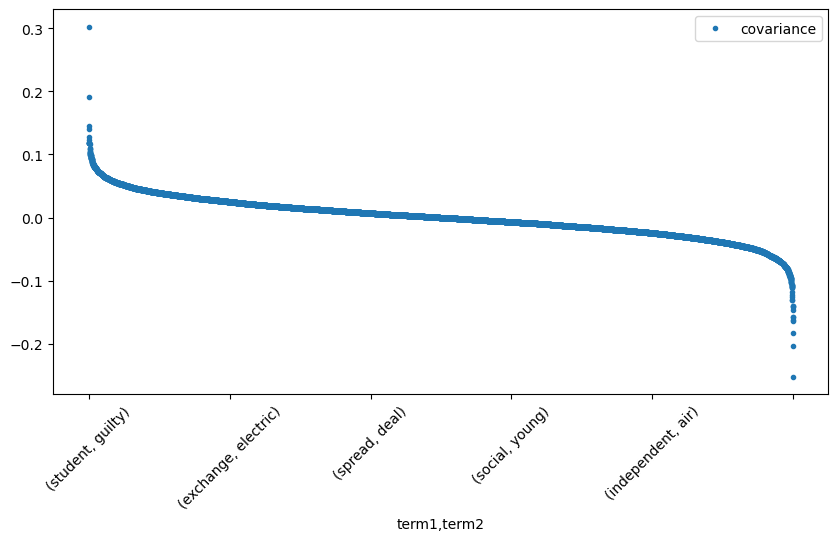

In [49]:
eig_vec_covar = EIG_VEC_PAIRS.sample(10000).sort_values('covariance', ascending=False).plot(rot=45, style='.', figsize=(10,5));

In [50]:
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)
EIG_PAIRS.sort_values('eig_val', ascending=False).head(10)

,eig_val,week,state,t,take,much,coronavirus,covid,house,election,...,blood,panel,russia,atlantic,hotel,produce,giuliani,friend,worry,path
term_str,,,,,,,,,,,,,,,,,,,,,
path,0.032172,0.001868,0.045520,0.045500,-0.005478,-0.007961,0.012440,-0.013102,0.156552,0.173554,...,-0.000453,-0.000405,0.026669,0.015146,0.008929,-0.010773,0.039201,0.007037,-0.004083,0.003465
worry,0.019628,0.002108,0.042799,-0.039933,-0.008777,-0.006942,-0.118362,-0.196931,-0.088596,0.155403,...,-0.036073,-0.018020,0.018287,-0.005129,0.002634,0.003137,-0.006469,0.001115,0.000403,0.006109
friend,0.018169,0.036516,-0.072569,-0.067598,0.003273,-0.015129,0.078049,0.080955,0.184633,-0.001324,...,-0.005048,0.008437,-0.006090,0.012080,-0.010415,0.008031,0.016464,-0.008779,-0.006564,0.007351
giuliani,0.016974,-0.058619,-0.001265,0.062410,-0.003357,-0.018898,-0.050216,-0.060383,-0.160347,0.071561,...,0.002704,-0.000495,0.010634,0.014336,0.002305,0.003769,0.008895,0.010083,-0.015824,-0.004600
produce,0.014041,-0.000819,-0.004462,-0.018727,-0.014866,-0.021154,-0.034871,-0.086501,0.153851,-0.049573,...,-0.004861,-0.010042,-0.002022,-0.006674,0.023112,-0.007305,0.030410,-0.000333,-0.009726,-0.003140
hotel,0.013440,-0.053904,-0.151065,0.068526,0.001260,0.032664,-0.060054,-0.105948,0.062377,-0.231962,...,0.006892,-0.010952,0.015544,0.024521,0.021823,0.005731,-0.023635,0.019968,-0.001788,0.002946
atlantic,0.012667,-0.022443,0.010729,-0.063105,0.012183,0.013051,0.028851,0.055684,-0.098784,-0.081477,...,-0.008006,0.007568,0.023140,-0.003502,0.025273,0.010561,-0.002823,-0.011881,-0.012279,-0.007231
russia,0.010774,-0.014334,0.038729,-0.016228,-0.015889,-0.042359,-0.013087,0.035543,0.031482,0.036281,...,-0.002917,0.007851,0.018369,0.002837,0.004036,0.000972,0.023798,-0.014331,-0.003104,-0.009007
panel,0.010268,-0.038175,0.069941,0.030296,-0.024225,0.013319,-0.003286,-0.006755,0.058511,0.159299,...,0.003749,-0.001822,-0.028443,0.009490,0.020854,0.000554,0.031507,0.005634,-0.002755,-0.002339


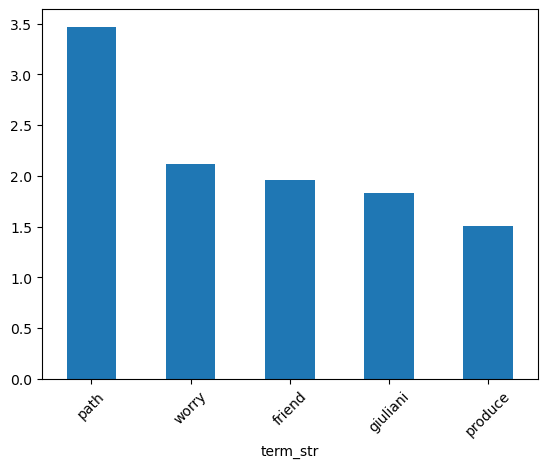

In [51]:
EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)
EIG_PAIRS_VIZ = EIG_PAIRS.exp_var.sort_values(ascending=False).head().plot.bar(rot=45);

In [52]:
COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)
COMPS.index.name = 'comp_id'
COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
COMPS.index.name = 'pc_id'
COMPS

,eig_val,week,state,t,take,much,coronavirus,covid,house,election,...,panel,russia,atlantic,hotel,produce,giuliani,friend,worry,path,exp_var
pc_id,,,,,,,,,,,,,,,,,,,,,
PC0,0.032172,0.001868,0.045520,0.045500,-0.005478,-0.007961,0.012440,-0.013102,0.156552,0.173554,...,-0.000405,0.026669,0.015146,0.008929,-0.010773,0.039201,0.007037,-0.004083,0.003465,3.47
PC1,0.019628,0.002108,0.042799,-0.039933,-0.008777,-0.006942,-0.118362,-0.196931,-0.088596,0.155403,...,-0.018020,0.018287,-0.005129,0.002634,0.003137,-0.006469,0.001115,0.000403,0.006109,2.12
PC2,0.018169,0.036516,-0.072569,-0.067598,0.003273,-0.015129,0.078049,0.080955,0.184633,-0.001324,...,0.008437,-0.006090,0.012080,-0.010415,0.008031,0.016464,-0.008779,-0.006564,0.007351,1.96
PC3,0.016974,-0.058619,-0.001265,0.062410,-0.003357,-0.018898,-0.050216,-0.060383,-0.160347,0.071561,...,-0.000495,0.010634,0.014336,0.002305,0.003769,0.008895,0.010083,-0.015824,-0.004600,1.83
PC4,0.014041,-0.000819,-0.004462,-0.018727,-0.014866,-0.021154,-0.034871,-0.086501,0.153851,-0.049573,...,-0.010042,-0.002022,-0.006674,0.023112,-0.007305,0.030410,-0.000333,-0.009726,-0.003140,1.51
PC5,0.013440,-0.053904,-0.151065,0.068526,0.001260,0.032664,-0.060054,-0.105948,0.062377,-0.231962,...,-0.010952,0.015544,0.024521,0.021823,0.005731,-0.023635,0.019968,-0.001788,0.002946,1.45
PC6,0.012667,-0.022443,0.010729,-0.063105,0.012183,0.013051,0.028851,0.055684,-0.098784,-0.081477,...,0.007568,0.023140,-0.003502,0.025273,0.010561,-0.002823,-0.011881,-0.012279,-0.007231,1.37
PC7,0.010774,-0.014334,0.038729,-0.016228,-0.015889,-0.042359,-0.013087,0.035543,0.031482,0.036281,...,0.007851,0.018369,0.002837,0.004036,0.000972,0.023798,-0.014331,-0.003104,-0.009007,1.16
PC8,0.010268,-0.038175,0.069941,0.030296,-0.024225,0.013319,-0.003286,-0.006755,0.058511,0.159299,...,-0.001822,-0.028443,0.009490,0.020854,0.000554,0.031507,0.005634,-0.002755,-0.002339,1.11


In [53]:
LOADINGS = COMPS[COV.index].T
LOADINGS.index.name = 'term_str'

In [54]:
LOADINGS.head(10).style.background_gradient(cmap=colors)

pc_id,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
term_str,,,,,,,,,,
week,0.001868,0.002108,0.036516,-0.058619,-0.000819,-0.053904,-0.022443,-0.014334,-0.038175,-0.028635
state,0.045520,0.042799,-0.072569,-0.001265,-0.004462,-0.151065,0.010729,0.038729,0.069941,-0.037990
t,0.045500,-0.039933,-0.067598,0.062410,-0.018727,0.068526,-0.063105,-0.016228,0.030296,-0.019008
take,-0.005478,-0.008777,0.003273,-0.003357,-0.014866,0.001260,0.012183,-0.015889,-0.024225,0.016974
much,-0.007961,-0.006942,-0.015129,-0.018898,-0.021154,0.032664,0.013051,-0.042359,0.013319,0.029199
coronavirus,0.012440,-0.118362,0.078049,-0.050216,-0.034871,-0.060054,0.028851,-0.013087,-0.003286,-0.019029
covid,-0.013102,-0.196931,0.080955,-0.060383,-0.086501,-0.105948,0.055684,0.035543,-0.006755,-0.021630
house,0.156552,-0.088596,0.184633,-0.160347,0.153851,0.062377,-0.098784,0.031482,0.058511,0.005025
election,0.173554,0.155403,-0.001324,0.071561,-0.049573,-0.231962,-0.081477,0.036281,0.159299,0.054616


In [55]:
top_terms = []
for i in range(10):
    for j in [0, 1]:
        comp_str = ' '.join(LOADINGS.sort_values(f'PC{i}', ascending=bool(j)).head(10).index.to_list())
        top_terms.append((f"PC{i}", j, comp_str))
COMP_GLOSS = pd.DataFrame(top_terms).set_index([0,1]).unstack()
COMP_GLOSS.index.name = 'comp_id'
COMP_GLOSS.columns = COMP_GLOSS.columns.droplevel(0) 
COMP_GLOSS = COMP_GLOSS.rename(columns={0:'pos', 1:'neg'})
COMP_GLOSS

1,pos,neg
comp_id,,
PC0,trump biden president election white house cam...,company stock share trading market quarter rev...
PC1,biden tax election stock trump share company r...,virus covid positive cdc health dr vaccine dis...
PC2,stock house white positive trump share company...,police tax court black income attorney county ...
PC3,police company black share stock biden county ...,tax stimulus relief income aid bill unemployme...
PC4,quarantine police positive house white court m...,biden vaccine health debate u climate cdc covi...
PC5,i security trump social tax white debate polic...,court election mail vote state vaccine voting ...
PC6,tax quarantine trump york vaccine income manha...,black police relief stimulus pelosi senate aid...
PC7,police vaccine tax security revenue social bla...,quarantine biden debate i negative guilty manh...
PC8,tax mail election voting income county vote ea...,police vaccine biden department quarantine att...
